In [1]:
from typing import Tuple
from itertools import chain, repeat, islice

from IPython.display import display, Latex
from sympy import (
    init_printing, Expr, Symbol, symbols, I, pi, oo, Rational, exp, Ynm, Abs, cos, sin, arg, sqrt, re, legendre, cancel,
    expand_func, simplify, expand, solve,
)

init_printing()

In [2]:
# %% pads
c_psp, c_pdp, c_sp, c_dp, c_fdp = symbols('c_psp c_pdp c_sp c_dp c_fdp', real=True)
eta_s, eta_psp, eta_pdp, eta_d, eta_f = symbols('eta_sp eta_psp eta_pdp eta_dp eta_fdp', real=True)
phi, the, vphi = symbols('phi theta varphi', real=True)

c0_sp = -sqrt(3)/3 * c_sp
c0_dp, c1_dp = sqrt(30)/15 * c_dp, sqrt(10)/10 * c_dp
c0_psp = -Rational(1, 3) * c_psp
c0_pdp, c1_pdp = -Rational(2, 15) * c_pdp, -Rational(1, 10) * c_pdp
c0_fdp, c1_fdp = sqrt(14)/35 * c_fdp, 2*sqrt(21)/105 * c_fdp

waves = {
    'm=0': (c0_psp * exp(eta_psp*I) * Ynm(1, 0, the, vphi) +
            c0_pdp * exp(eta_pdp*I) * Ynm(1, 0, the, vphi) +
            c0_fdp * exp(eta_f*I) * Ynm(3, 0, the, vphi) +
            c0_sp * exp(eta_s*I + phi*I) * Ynm(0, 0, the, vphi) +
            c0_dp * exp(eta_d*I + phi*I) * Ynm(2, 0, the, vphi)),
    'm=1': (c1_pdp * exp(eta_pdp*I) * Ynm(1, 1, the, vphi) +
            c1_fdp * exp(eta_f*I) * Ynm(3, 1, the, vphi) +
            c1_dp * exp(eta_d*I + phi*I) * Ynm(2, 1, the, vphi)),
}
pads = {
    k: sum(Abs(term) ** 2 for term in expr)
    for k, expr in {
        'm=0': [waves['m=0']],
        'm=1': [waves['m=1']],
        'summed': [waves['m=1'].subs(vphi, -vphi), waves['m=0'], waves['m=1']],
    }.items()
}

In [3]:
# %% solve pad eq
def expend_cos(expr: Expr, x: Symbol) -> Tuple[Expr, Expr]:
    while True:
        term = expr.subs(x, pi / 2)
        yield term
        expr = cancel((expr - term) / cos(x))
        if expr == 0:
            return


def amp_and_shift(expr: Expr, x: Symbol) -> Tuple[Expr, Expr]:
    amp = simplify(cancel(sqrt(expr ** 2 + expr.diff(x) ** 2).subs(x, 0)))
    shift = arg(expr.subs(x, 0) + I * expr.diff(x).subs(x, 0))
    return amp, shift


def solve_eq(pad: Expr) -> dict:
    # expand left term
    left = (
        expand_func(pad)
        .subs(sin(the) ** 2, 1 - cos(the) ** 2)
    )
    terms_lft = list(islice(chain(expend_cos(left, the), repeat(0)), 7))

    # expand right term
    b0, b1, b2, b3, b4, b5, b6 = symbols(
        'b_0 b_1 b_2 b_3 b_4 b_5 b_6',
        real=True
    )
    right = (b0 +
             b1 * legendre(1, cos(the)) +
             b2 * legendre(2, cos(the)) +
             b3 * legendre(3, cos(the)) +
             b4 * legendre(4, cos(the)) +
             b5 * legendre(5, cos(the)) +
             b6 * legendre(6, cos(the)))
    terms_rgt = list(expend_cos(right, the))

    # solve equations
    b6_cmpx = simplify(cancel(solve(terms_lft[6] - terms_rgt[6], b6)[0]))
    b6_real = simplify(re(expand(b6_cmpx)))

    b5_cmpx = simplify(cancel(solve(terms_lft[5] - terms_rgt[5], b5)[0]))
    b5_real = simplify(re(expand(b5_cmpx)))
    b5_amp, b5_shift = amp_and_shift(b5_real, phi)

    b4_cmpx = simplify(cancel(solve((terms_lft[4] - terms_rgt[4])
                                    .subs(b6, b6_cmpx), b4)[0]))
    b4_real = simplify(re(expand(b4_cmpx)))

    b3_cmpx = simplify(cancel(solve((terms_lft[3] - terms_rgt[3])
                                    .subs(b5, b5_cmpx), b3)[0]))
    b3_real = simplify(re(expand(b3_cmpx)))
    b3_amp, b3_shift = amp_and_shift(b3_real, phi)

    b2_cmpx = simplify(cancel(solve((terms_lft[2] - terms_rgt[2])
                                    .subs(b6, b6_cmpx)
                                    .subs(b4, b4_cmpx), b2)[0]))
    b2_real = simplify(re(expand(b2_cmpx)))

    b1_cmpx = simplify(cancel(solve((terms_lft[1] - terms_rgt[1])
                                    .subs(b5, b5_cmpx)
                                    .subs(b3, b3_cmpx), b1)[0]))
    b1_real = simplify(re(expand(b1_cmpx)))
    b1_amp, b1_shift = amp_and_shift(b1_real, phi)

    b0_cmpx = simplify(cancel(solve((terms_lft[0] - terms_rgt[0])
                                    .subs(b6, b6_cmpx)
                                    .subs(b4, b4_cmpx)
                                    .subs(b2, b2_cmpx), b0)[0]))
    b0_real = simplify(re(expand(b0_cmpx)))

    b1m3_real = simplify(cancel(b1_real - b3_real * 3 / 2))
    b1m3_amp, b1m3_shift = amp_and_shift(b1m3_real, phi)
    return {
        'b0': b0_real,

        'b1': b1_real,
        'b1_amp': b1_amp,
        'b1_shift': b1_shift,
        'beta1': b1_real / b0_real,
        'beta1_amp': b1_amp / b0_real,
        'beta1_shift': b1_shift,

        'b2': b2_real,
        'beta2': b2_real / b0_real,

        'b3': b3_real,
        'b3_amp': b3_amp,
        'b3_shift': b3_shift,
        'beta3': b3_real / b0_real,
        'beta3_amp': b3_amp / b0_real,
        'beta3_shift': b3_shift,

        'b4': b4_real,
        'beta4': b4_real / b0_real,

        'b5': b5_real,
        'b5_amp': b5_amp,
        'b5_shift': b5_shift,
        'beta5': b5_real / b0_real,
        'beta5_amp': b5_amp / b0_real,
        'beta5_shift': b5_shift,

        'b6': b6_real,
        'beta6': b6_real / b0_real,

        'b1m3': b1m3_real,
        'b1m3_amp': b1m3_amp,
        'b1m3_shift': b1m3_shift,
        'beta1m3': b1m3_real / b0_real,
        'beta1m3_amp': b1m3_amp / b0_real,
        'beta1m3_shift': b1m3_shift,
    }

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

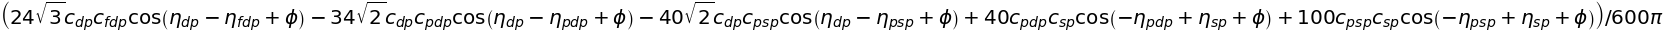

<IPython.core.display.Latex object>

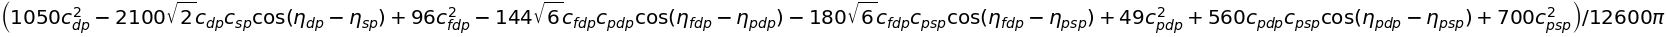

<IPython.core.display.Latex object>

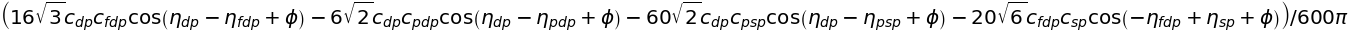

<IPython.core.display.Latex object>

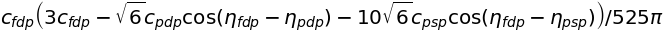

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [4]:
solved = solve_eq(pads['summed'])
for k, v in [
        [r"$b_0=$", "b0"],
        [r"$b_1=$", "b1"],
        [r"$b_2=$", "b2"],
        [r"$b_3=$", "b3"],
        [r"$b_4=$", "b4"],
        [r"$b_5=$", "b5"],
        [r"$b_6=$", "b6"],
    ]:
    display(Latex(k))
    display(solved[f"{v}"])
    print()

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

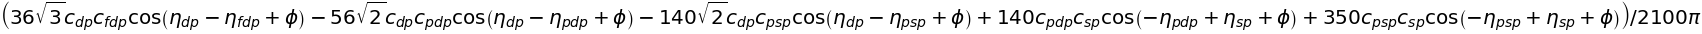

<IPython.core.display.Latex object>

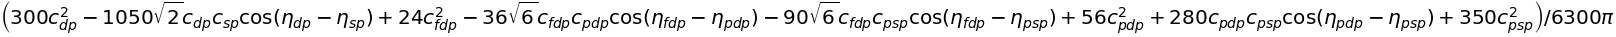

<IPython.core.display.Latex object>

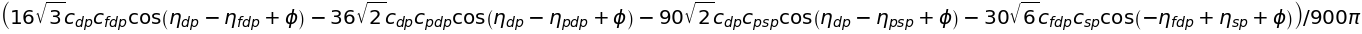

<IPython.core.display.Latex object>

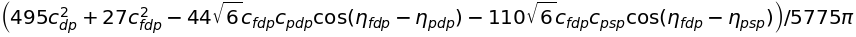

<IPython.core.display.Latex object>

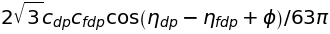

<IPython.core.display.Latex object>

In [5]:
solved = solve_eq(pads['m=0'])
for k, v in [
        [r"$b_0=$", "b0"],
        [r"$b_1=$", "b1"],
        [r"$b_2=$", "b2"],
        [r"$b_3=$", "b3"],
        [r"$b_4=$", "b4"],
        [r"$b_5=$", "b5"],
        [r"$b_6=$", "b6"],
    ]:
    display(Latex(k))
    display(solved[f"{v}"])
    print()

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

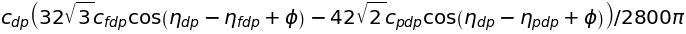

<IPython.core.display.Latex object>

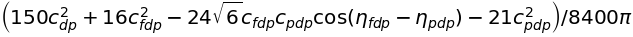

<IPython.core.display.Latex object>

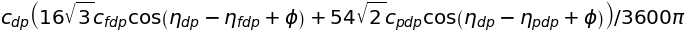

<IPython.core.display.Latex object>

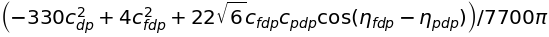

<IPython.core.display.Latex object>

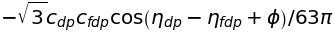

<IPython.core.display.Latex object>

In [6]:
solved = solve_eq(pads['m=1'])
for k, v in [
        [r"$b_0=$", "b0"],
        [r"$b_1=$", "b1"],
        [r"$b_2=$", "b2"],
        [r"$b_3=$", "b3"],
        [r"$b_4=$", "b4"],
        [r"$b_5=$", "b5"],
        [r"$b_6=$", "b6"],
    ]:
    display(Latex(k))
    display(solved[f"{v}"])
    print()